In [29]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
data = pd.read_csv('/content/Breast_cancer_data.csv')

   mean_radius  mean_texture  mean_perimeter  mean_area  mean_smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   diagnosis  
0          0  
1          0  
2          0  
3          0  
4          0  
       mean_radius  mean_texture  mean_perimeter    mean_area  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min       6.981000      9.710000       43.790000   143.500000   
25%      11.700000     16.170000       75.170000   420.300000   
50%      13.370000     18.840000       86.240000   551.100000  

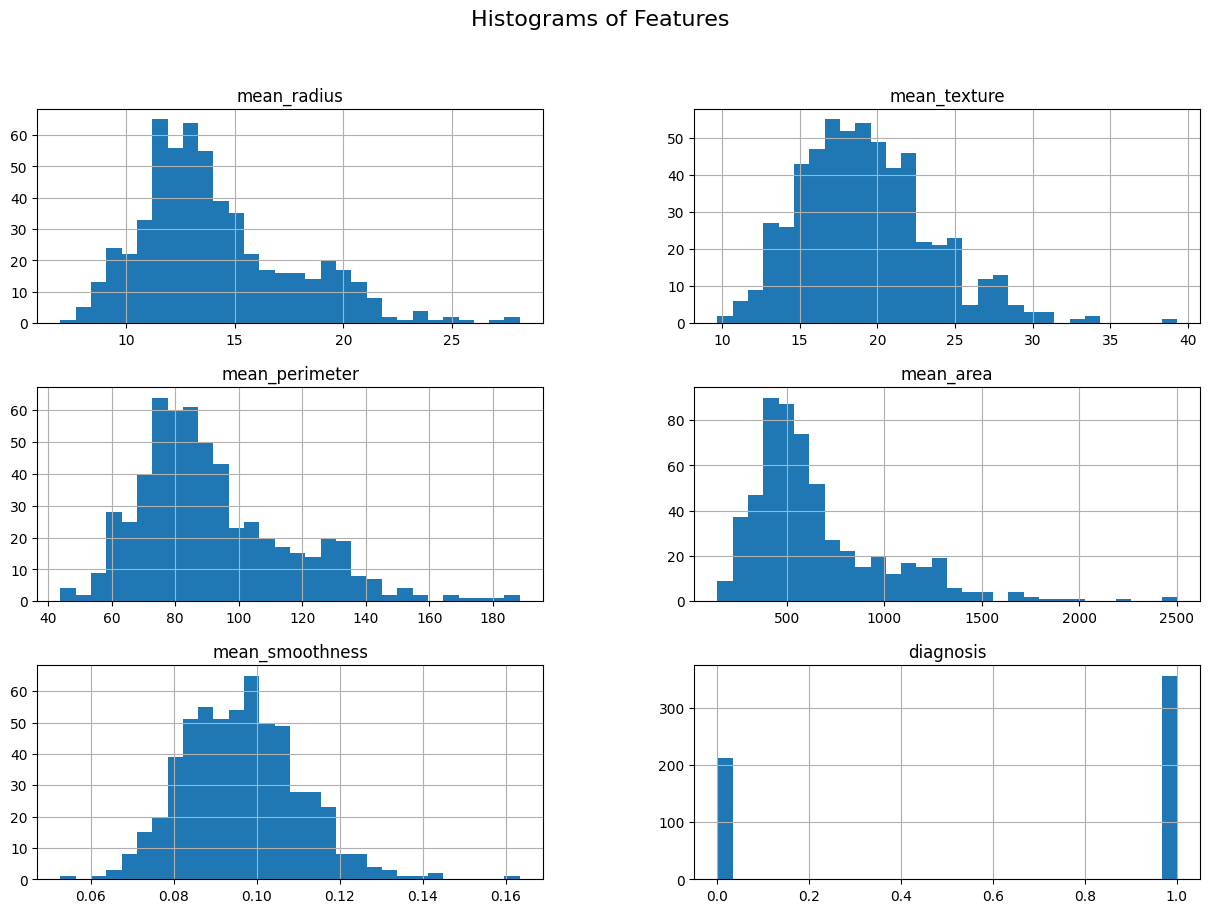

In [31]:
print(data.head())
print(data.describe())
print(data.isnull().sum())

# Visualizing the distribution of key features using histograms
data.hist(bins=30, figsize=(15, 10))
plt.suptitle('Histograms of Features', size=16)
plt.show()

In [32]:
# Function to calculate Gini Index
def gini_index(groups, classes):
    n_instances = float(sum([len(group) for group in groups]))
    gini = 0.0
    for group in groups:
        size = float(len(group))
        if size == 0:
            continue
        score = 0.0
        for class_val in classes:
            p = [row[-1] for row in group].count(class_val) / size
            score += p * p
        gini += (1.0 - score) * (size / n_instances)
    return gini

In [33]:
# Function to split the dataset
def test_split(index, value, dataset):
    left, right = [], []
    for row in dataset:
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right

In [34]:
# Function to get the best split
def get_split(dataset):
    class_values = list(set(row[-1] for row in dataset))
    b_index, b_value, b_score, b_groups = 999, 999, 999, None
    for index in range(len(dataset[0]) - 1):
        for row in dataset:
            groups = test_split(index, row[index], dataset)
            gini = gini_index(groups, class_values)
            if gini < b_score:
                b_index, b_value, b_score, b_groups = index, row[index], gini, groups
    return {'index': b_index, 'value': b_value, 'groups': b_groups}


In [35]:
# Function to create a terminal node
def to_terminal(group):
    outcomes = [row[-1] for row in group]
    return max(set(outcomes), key=outcomes.count)


In [36]:
# Recursive splitting
def split(node, max_depth, min_size, depth):
    left, right = node['groups']
    del(node['groups'])
    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)
        return
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    if len(left) <= min_size:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_split(left)
        split(node['left'], max_depth, min_size, depth+1)
    if len(right) <= min_size:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_split(right)
        split(node['right'], max_depth, min_size, depth+1)

# Function to build a decision tree
def build_tree(train, max_depth, min_size):
    root = get_split(train)
    split(root, max_depth, min_size, 1)
    return root

In [37]:
# Make a prediction with the decision tree
def predict(node, row):
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']


In [38]:
dataset = data.values.tolist()
train_size = int(0.8 * len(dataset))
train_set = dataset[:train_size]
test_set = dataset[train_size:]


In [39]:
# Build the decision tree
max_depth = 5
min_size = 10
tree = build_tree(train_set, max_depth, min_size)

In [40]:
# Predict the outcomes for the test set
predictions = [predict(tree, row) for row in test_set]

# Get the actual outcomes
actual = [row[-1] for row in test_set]

In [41]:
accuracy = sum([1 for i in range(len(actual)) if actual[i] == predictions[i]]) / float(len(actual)) * 100
print(f'Accuracy: {accuracy}%')


Accuracy: 87.71929824561403%


Confusion Matrix:
[[25  1]
 [13 75]]


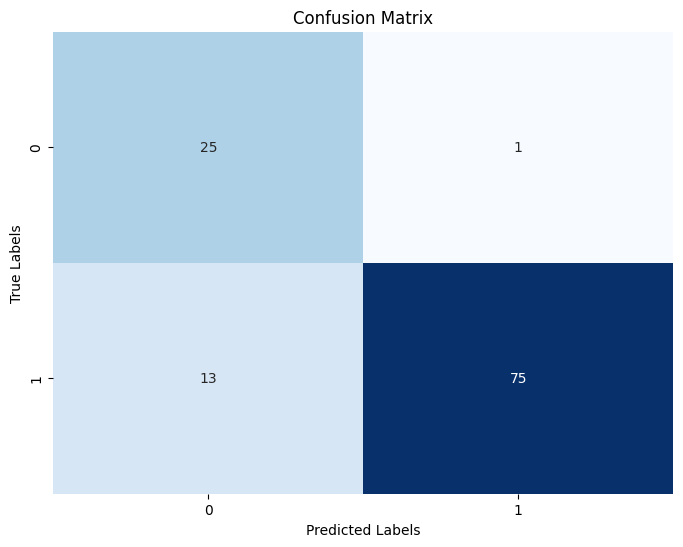

In [42]:
cm = confusion_matrix(actual, predictions)
print('Confusion Matrix:')
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [43]:
print('Classification Report:')
print(classification_report(actual, predictions))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.66      0.96      0.78        26
         1.0       0.99      0.85      0.91        88

    accuracy                           0.88       114
   macro avg       0.82      0.91      0.85       114
weighted avg       0.91      0.88      0.88       114



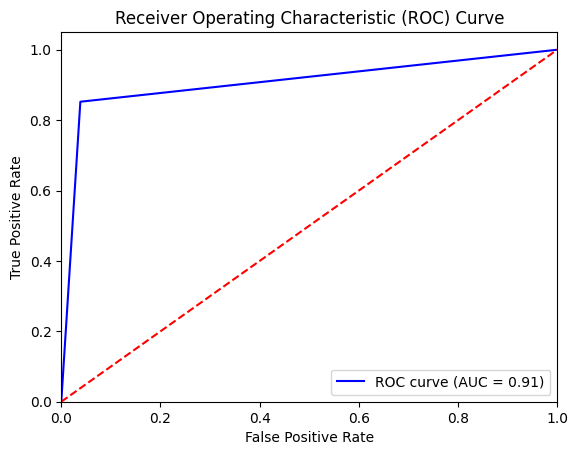

In [44]:
fpr, tpr, thresholds = roc_curve(actual, predictions)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
